In [113]:
from rclpy.time import Time
from pathlib import Path
from rosbags.rosbag2 import Reader
from rosbags.typesys import Stores, get_typestore, get_types_from_msg
import numpy as np
import matplotlib.pyplot as plt
from builtin_interfaces.msg import Time as Time_msg
from matplotlib.patches import Circle, Rectangle
import ff_control.ff_control.transformer_controller.ff_scenario as ff
%matplotlib ipympl

typestore = get_typestore(Stores.ROS2_HUMBLE)
add_types = {}
add_types.update(get_types_from_msg(Path('ff_msgs/msg/Pose2D.msg').read_text(), 'ff_msgs/msg/Pose2D'))
add_types.update(get_types_from_msg(Path('ff_msgs/msg/Twist2D.msg').read_text(), 'ff_msgs/msg/Twist2D'))
add_types.update(get_types_from_msg(Path('ff_msgs/msg/FreeFlyerState.msg').read_text(), 'ff_msgs/msg/FreeFlyerState'))
add_types.update(get_types_from_msg(Path('ff_msgs/msg/FreeFlyerStateStamped.msg').read_text(), 'ff_msgs/msg/FreeFlyerStateStamped'))
add_types.update(get_types_from_msg(Path('ff_msgs/msg/ThrusterCommand.msg').read_text(), 'ff_msgs/msg/ThrusterCommand'))
typestore.register(add_types)

def import_bag(bag_path):
    # create reader instance and open for reading
    with Reader(bag_path) as reader:
        # topic and msgtype information is available on .connections list
        for connection in reader.connections:
            print(connection.topic, connection.msgtype)

        # iterate over messages
        goal_msg = []
        state_msg = []
        action_msg = []
        for connection, timestamp, rawdata in reader.messages():
            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)
            if connection.topic == '/robot/robot/goal':
                goal_msg.append(msg)
            elif connection.topic == '/robot/commands/binary_thrust':
                action_msg.append(msg)
            elif connection.topic == '/robot/est/state':
                state_msg.append(msg)

    def time2float(time:Time_msg) -> float:
        return time.sec + time.nanosec*1e-9
    
    # Import goal and compute initial time
    goal = {
        'time' : np.array([time2float(g.header.stamp) for g in goal_msg]),
        'x' : np.array([g.state.pose.x for g in goal_msg]),
        'y' : np.array([g.state.pose.y for g in goal_msg]),
        'psi' : np.array([g.state.pose.theta for g in goal_msg]),
        'vx' : np.array([g.state.twist.vx for g in goal_msg]),
        'vy' : np.array([g.state.twist.vy for g in goal_msg]),
        'wz' : np.array([g.state.twist.wz for g in goal_msg])
    }
    time_i_goal = goal['time'][0]
    goal['time'] = goal['time'] - time_i_goal

    # Import state and actions from the initial time onwards
    state_time = np.array([time2float(s.header.stamp) for s in state_msg])
    state = {
        'time' : state_time[state_time >= time_i_goal] - time_i_goal,
        'x' : np.array([s.state.pose.x for s in state_msg])[state_time >= time_i_goal],
        'y' : np.array([s.state.pose.y for s in state_msg])[state_time >= time_i_goal],
        'psi' : np.array([s.state.pose.theta for s in state_msg])[state_time >= time_i_goal],
        'vx' : np.array([s.state.twist.vx for s in state_msg])[state_time >= time_i_goal],
        'vy' : np.array([s.state.twist.vy for s in state_msg])[state_time >= time_i_goal],
        'wz' : np.array([s.state.twist.wz for s in state_msg])[state_time >= time_i_goal]
    }

    action_time = np.array([time2float(a.header.stamp) for a in action_msg])
    action = {
        'time' : action_time[action_time >= time_i_goal]  - time_i_goal,
        'switches' : (np.array([a.switches for a in action_msg]).T)[:, action_time >= time_i_goal]
    }

    return state, action, goal

In [151]:
state_TTOSCP, action_TTOSCP, goal_TTOSCP = import_bag(bag_path='./../../bags/closed_loop/corridoioTTOMPC')
state_CVXSCP, action_CVXSCP, goal_CVXSCP = import_bag(bag_path='./../../bags/closed_loop/corridoioSCPMPC') # AVEVAMO MESSO r=0.23 m per evitare sbattesse???????????????????????????????????????????''

/robot/robot/goal ff_msgs/msg/FreeFlyerStateStamped
/robot/est/state ff_msgs/msg/FreeFlyerStateStamped
/robot/commands/binary_thrust ff_msgs/msg/ThrusterCommand
/robot/robot/goal ff_msgs/msg/FreeFlyerStateStamped
/robot/est/state ff_msgs/msg/FreeFlyerStateStamped
/robot/commands/binary_thrust ff_msgs/msg/ThrusterCommand


In [152]:
def ff_plot(state_list, goal_list, case_list, color_list):
    fig, ax = plt.subplots(figsize=(15,10))
    for state, goal, color, case in zip(state_list, goal_list, color_list, case_list):
        ax.plot(state['x'], state['y'], color[0], linewidth=3,  label='state_'+case, zorder=3)
        ax.plot(goal['x'], goal['y'], color[1], linewidth=3, label='goal_'+case, zorder=3)
    ax.add_patch(Rectangle((0,0), ff.table['xy_up'][0], ff.table['xy_up'][1], fc=(0.5,0.5,0.5,0.2), ec='k', label='table', zorder=2.5))
    for n_obs in range(ff.obs['radius'].shape[0]):
        label_obs = 'obs' if n_obs == 0 else None
        label_robot = 'robot radius' if n_obs == 0 else None
        ax.add_patch(Circle(ff.obs['position'][n_obs,:], ff.obs['radius'][n_obs], fc='r', label=label_obs, zorder=2.5))
        ax.add_patch(Circle(ff.obs['position'][n_obs,:], ff.obs['radius'][n_obs]+ff.robot_radius, fc='r', alpha=0.2, label=label_robot, zorder=2.5))
    ax.grid(True)
    ax.set_aspect('equal')
    ax.set_xlabel('X [m]', fontsize=10)
    ax.set_ylabel('Y [m]', fontsize=10)
    ax.grid(True)
    ax.legend(loc='best', fontsize=10)
    plt.show()

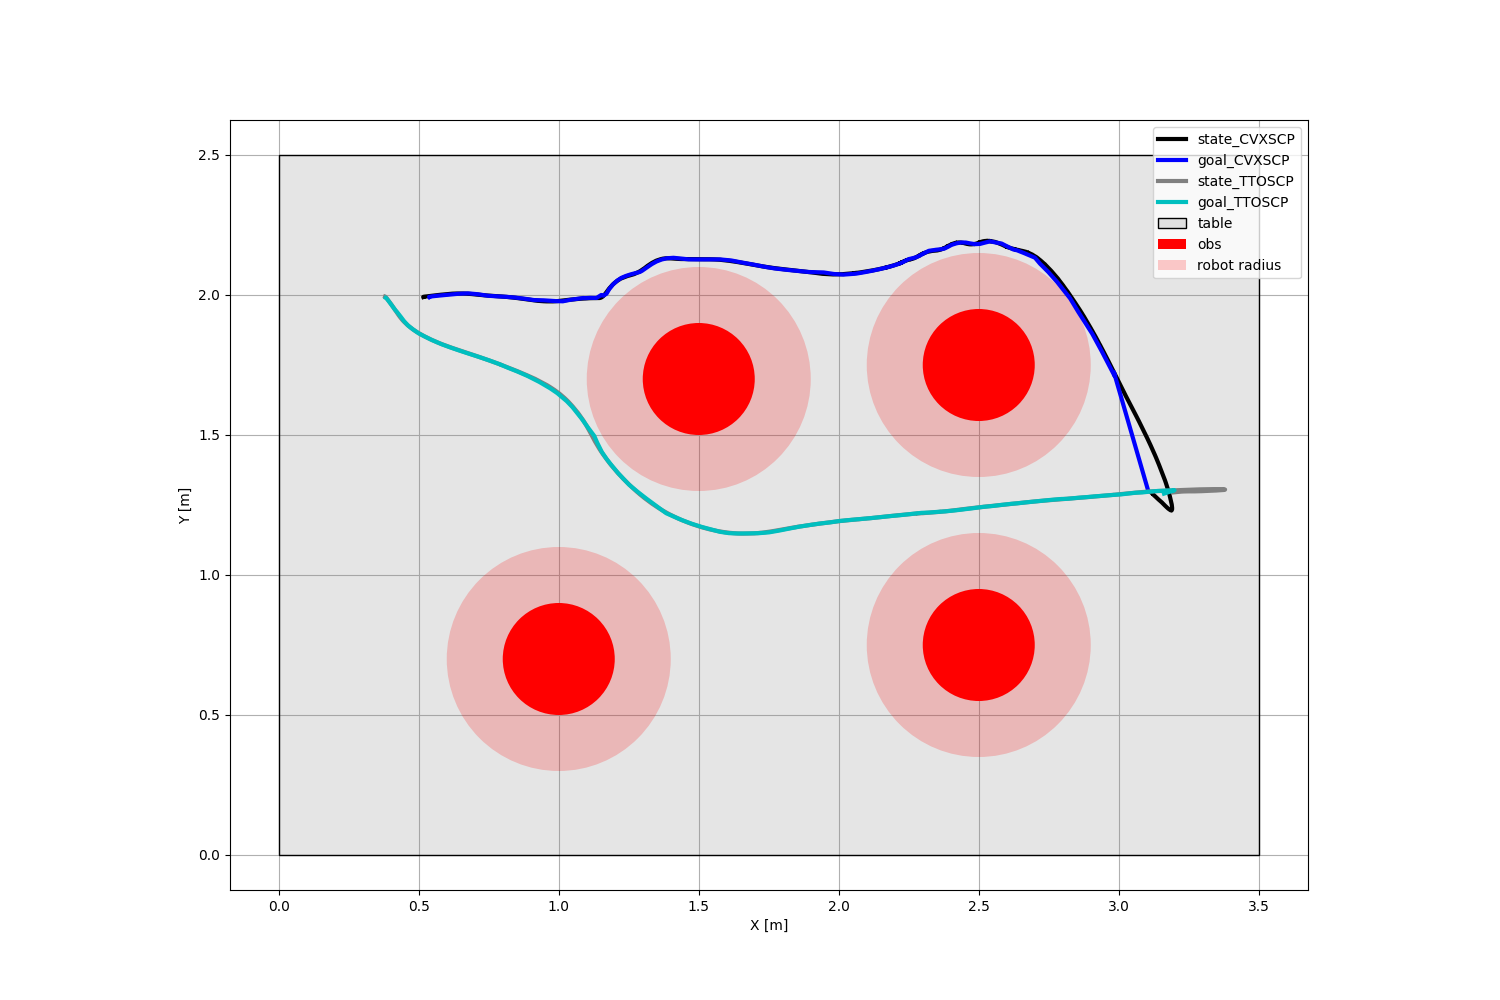

In [153]:
ff_plot([state_CVXSCP, state_TTOSCP], [goal_CVXSCP, goal_TTOSCP], ['CVXSCP','TTOSCP'], [['k','b'],['grey','c']])

In [154]:
def compute_consumption(action):
    tt = action['time']
    switches = action['switches']

    T_ON = np.zeros((switches.shape[0],))
    for i in range(switches.shape[0]):
        mask = switches[i,:-1]
        dts = tt[1:] - tt[:-1]
        T_ON[i] = np.sum(dts[mask])
    
    return T_ON

def performances_analysis(state_list, goal_list, action_list, case_list):
    n_case = len(case_list)
    mosaic = [['pos'+str(n) for n in range(n_case)],
              ['vel'+str(n) for n in range(n_case)],
              ['act'+str(n) for n in range(n_case)],
              ['act'+str(n) for n in range(n_case)],
              ['act'+str(n) for n in range(n_case)]]
    fig,ax = plt.subplot_mosaic(mosaic, figsize=(20,20))#subplots(4,n_case,figsize=(20,10))
    for n, (state, goal, action, case) in enumerate(zip(state_list, goal_list, action_list, case_list)):
        for i in range(2):
            state2show = ['x','y'] if i==0 else ['vx','vy']
            for j in range(len(state2show)):
                ax[mosaic[i][n]].plot(state['time'], state[state2show[j]], linewidth=2, label=state2show[j]+'_state_'+case)
                ax[mosaic[i][n]].plot(goal['time'], goal[state2show[j]], linewidth=2, label=state2show[j]+'_goal_'+case)
                ax[mosaic[i][n]].grid(True)
                ax[mosaic[i][n]].set_ylabel('Position [m]' if i==0 else 'Velocity [m/s]')
                ax[mosaic[i][n]].legend(loc='best')
        
        T_ON = compute_consumption(action)
        for i in range(action['switches'].shape[0]):
            ax['act'+str(n)].stem(action['time'], i+action['switches'][i]/2, linefmt='C'+str(i), markerfmt='C'+str(i)+'o', bottom = i)
            ax['act'+str(n)].text(-1.5, i+0.15, str(np.round(T_ON[i],2)), rotation='vertical')
        ax['act'+str(n)].set_title('Total firing time: '+str(np.round(T_ON.sum(),2))+' s')
        ax['act'+str(n)].set_ylabel('Thrustes [ON/OFF]')
        ax['act'+str(n)].set_xlabel('Time [s]')
        ax['act'+str(n)].grid(True)
    plt.show()

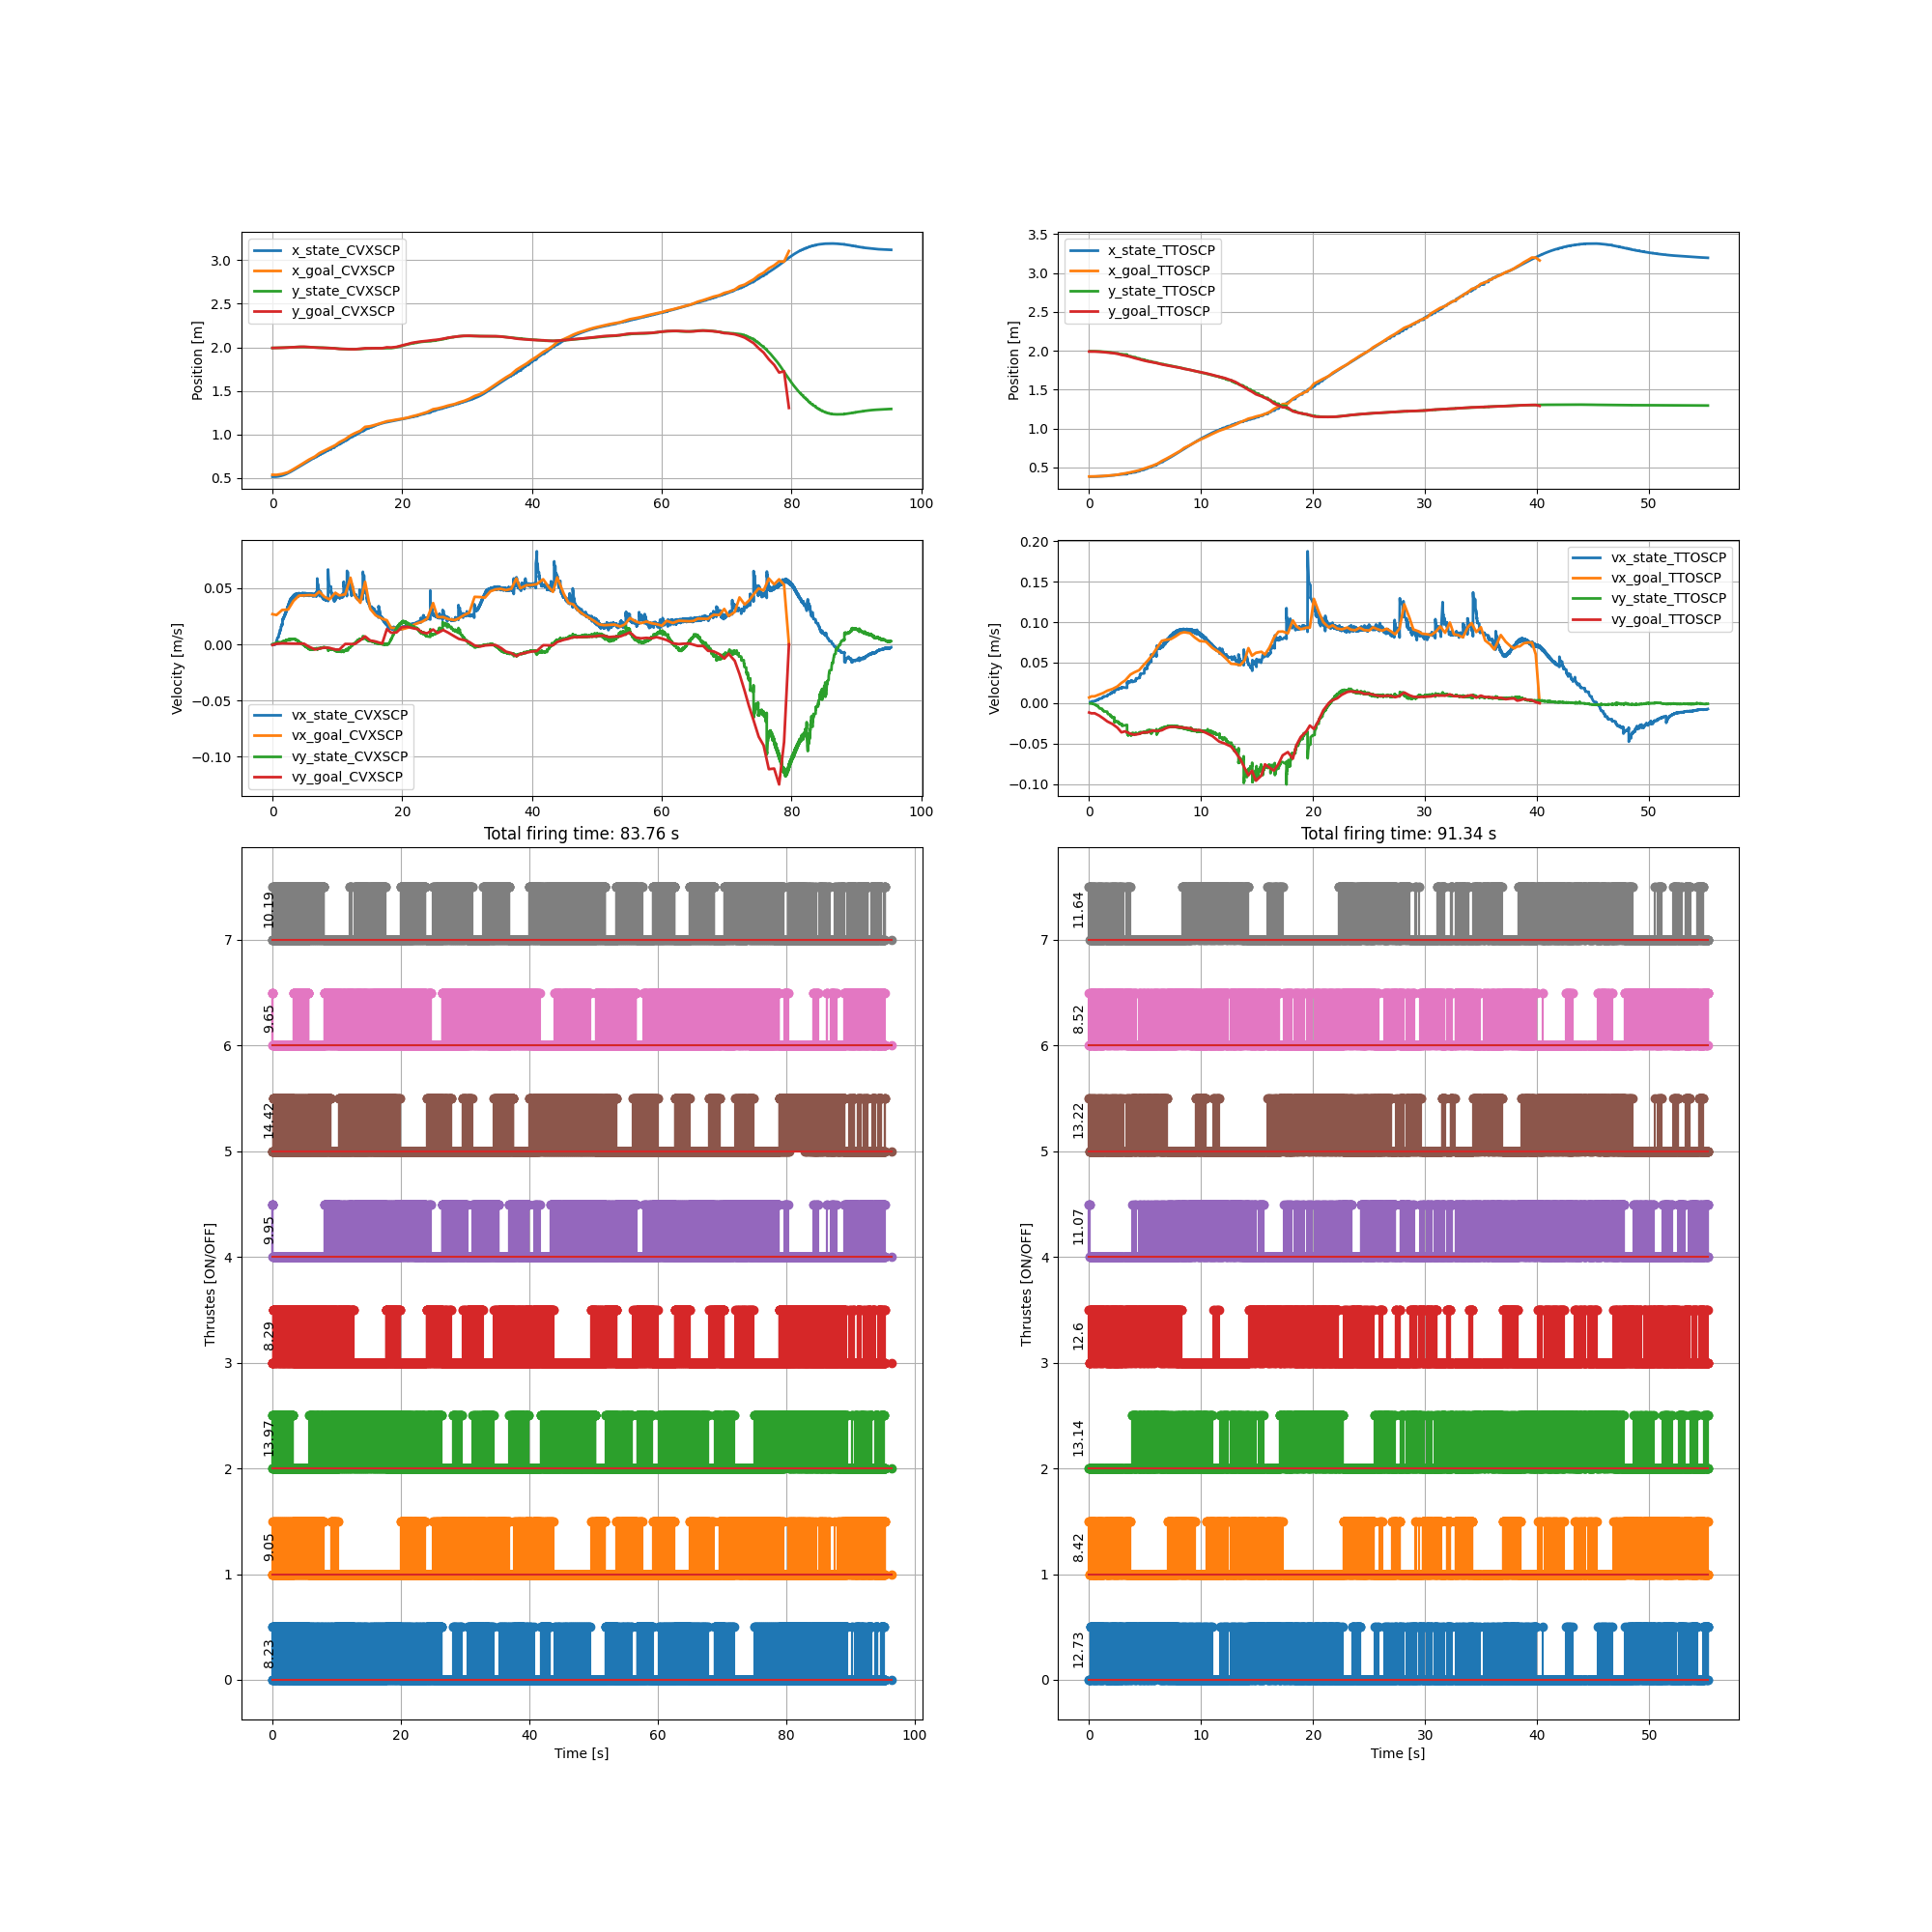

In [155]:
performances_analysis([state_CVXSCP, state_TTOSCP], [goal_CVXSCP, goal_TTOSCP], [action_CVXSCP, action_TTOSCP], ['CVXSCP','TTOSCP'])